In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.linalg import block_diag

In [2]:
# friction map:  [[0.09041 0.1     0.09041]
#                 [0.1     0.09041 0.09041]
#                 [0.1     0.1568  0.1    ]]

In [3]:
plt.close("all")

In [4]:
data = "../data/robot_data.csv"


In [5]:
df = pd.read_csv(data, index_col=0)

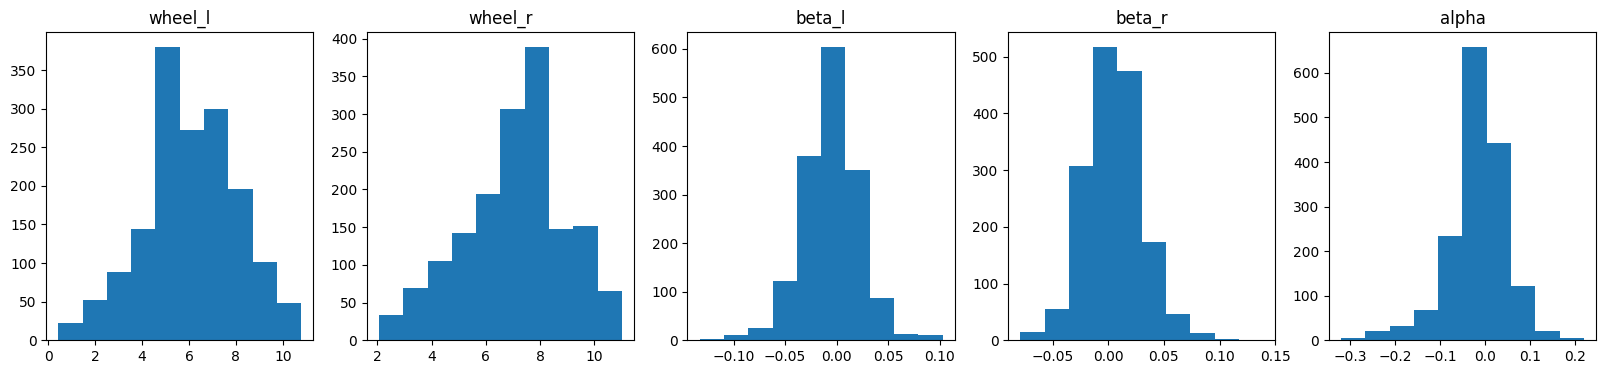

In [6]:
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
ax[0].hist(df.wheel_l)
ax[0].set_title('wheel_l')
ax[1].hist(df.wheel_r)
ax[1].set_title('wheel_r')
ax[2].hist(df.beta_l)
ax[2].set_title('beta_l')
ax[3].hist(df.beta_r)
ax[3].set_title('beta_r')
ax[4].hist(df.alpha)
ax[4].set_title('alpha')
plt.show()

In [7]:
df.wheel_l.min(), df.wheel_l.max()

(np.float64(0.4267151265630396), np.float64(10.783067100933334))

In [8]:
df.wheel_r.min(), df.wheel_r.max()

(np.float64(2.0596773360490124), np.float64(11.012253585859904))

In [9]:
df

,wheel_l,wheel_r,beta_l,beta_r,alpha,i,j
0,2.951473,3.223729,-0.025151,-0.023900,0.030320,1,2
1,4.195919,4.210596,-0.005108,0.009406,0.043215,1,2
2,5.499216,5.019863,-0.002574,-0.007017,0.115174,1,2
3,7.160615,5.695565,0.018772,-0.005655,0.062451,1,2
4,7.699737,4.763282,0.004853,-0.031695,0.037491,1,2
...,...,...,...,...,...,...,...
1600,6.946471,6.311675,0.024005,0.012848,0.010831,0,0
1601,7.493583,5.229431,-0.042428,-0.074166,0.036279,0,0
1602,7.759759,4.287623,-0.002554,-0.028976,-0.008676,0,1
1603,6.524105,5.077545,-0.012813,-0.034586,0.025582,0,1


In [10]:
i_filter = 0
j_filter = 1

In [11]:
# filtered = df[(df.i == i_filter) & (df.j == j_filter)]
# filtered

filtered = df

In [12]:
# filtered = filtered[(filtered.wheel_l > 9) & (filtered.wheel_r > 11)]
# filtered.sort_values(["wheel_l","wheel_r"])

In [13]:
omega_l = filtered.wheel_l.values
omega_r = filtered.wheel_r.values
beta_l = filtered.beta_l.values
beta_r = filtered.beta_r.values
alpha = filtered.alpha.values

In [14]:
# %matplotlib tk

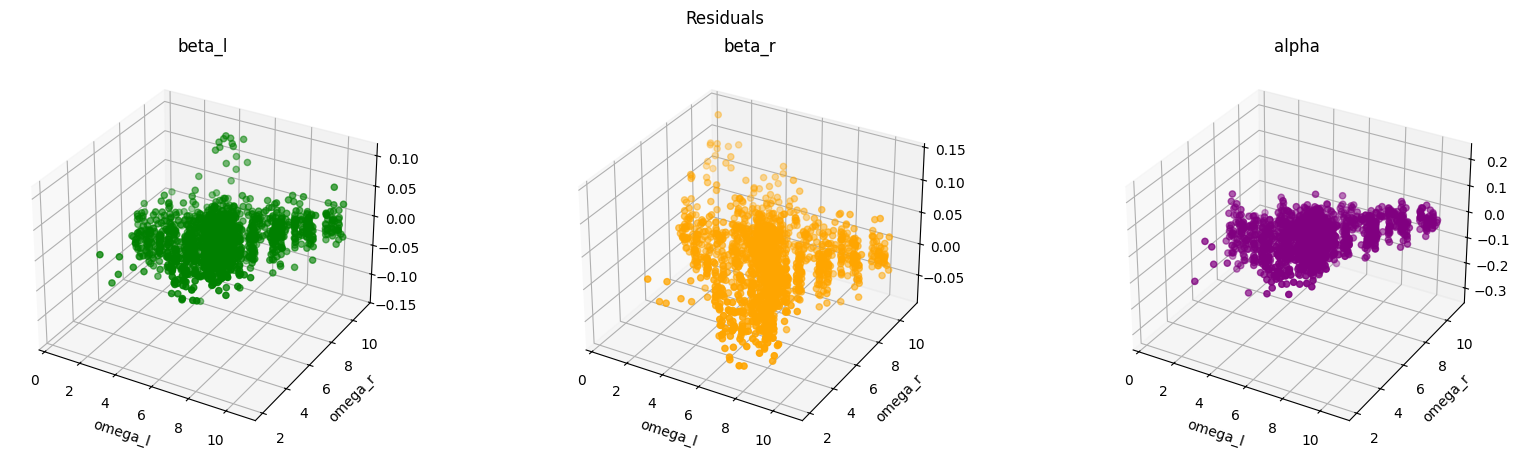

In [15]:
fig = plt.figure(figsize=(20, 5))
fig.suptitle("Residuals")

# Beta_l residuals
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(omega_l, omega_r, beta_l, color="green")
ax1.set_xlabel("omega_l")
ax1.set_ylabel("omega_r")
ax1.set_title("beta_l")
# ax1.view_init(0, 0, 0)

# Beta_r residuals
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(omega_l, omega_r, beta_r, color="orange")
ax2.set_xlabel("omega_l")
ax2.set_ylabel("omega_r")
ax2.set_title("beta_r")
# ax2.view_init(0, 0, 0)

# Alpha residuals
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(omega_l, omega_r, alpha, color="purple")
ax3.set_xlabel("omega_l")
ax3.set_ylabel("omega_r")
ax3.set_title("alpha")
# ax3.view_init(0, 0, 0)

plt.show()

In [16]:
X = np.column_stack((np.ones(len(omega_l)), omega_l, omega_r))
Y = np.column_stack((beta_l, beta_r, alpha))

In [17]:
# WLS regressor

weights_l = np.ones_like(Y[...,0])
weights_r = np.ones_like(Y[...,0])
weights_alpha = np.ones_like(Y[...,0])


W_l = np.diag(weights_l)
W_r = np.diag(weights_r)
W_alpha = np.diag(weights_alpha)

W = block_diag(W_l, W_r, W_alpha)

X_expanded = np.kron(np.eye(3), X)

XTWX_inv = np.linalg.inv(X_expanded.T @ W @ X_expanded)
XTWy = X_expanded.T @ W @ Y.flatten(order='F')
theta_hat_ols_flat = XTWX_inv @ XTWy

theta_hat_ols = theta_hat_ols_flat.reshape(3, -1).T
y_hat_ols = X @ theta_hat_ols

In [18]:
# # OLS regressor

# theta_hat_ols = np.linalg.inv(X.T @ X) @ (X.T @ Y)
# y_hat_ols = X @ theta_hat_ols

# theta_hat_ols

In [19]:
residuals_ols = Y - y_hat_ols

In [20]:
%matplotlib inline

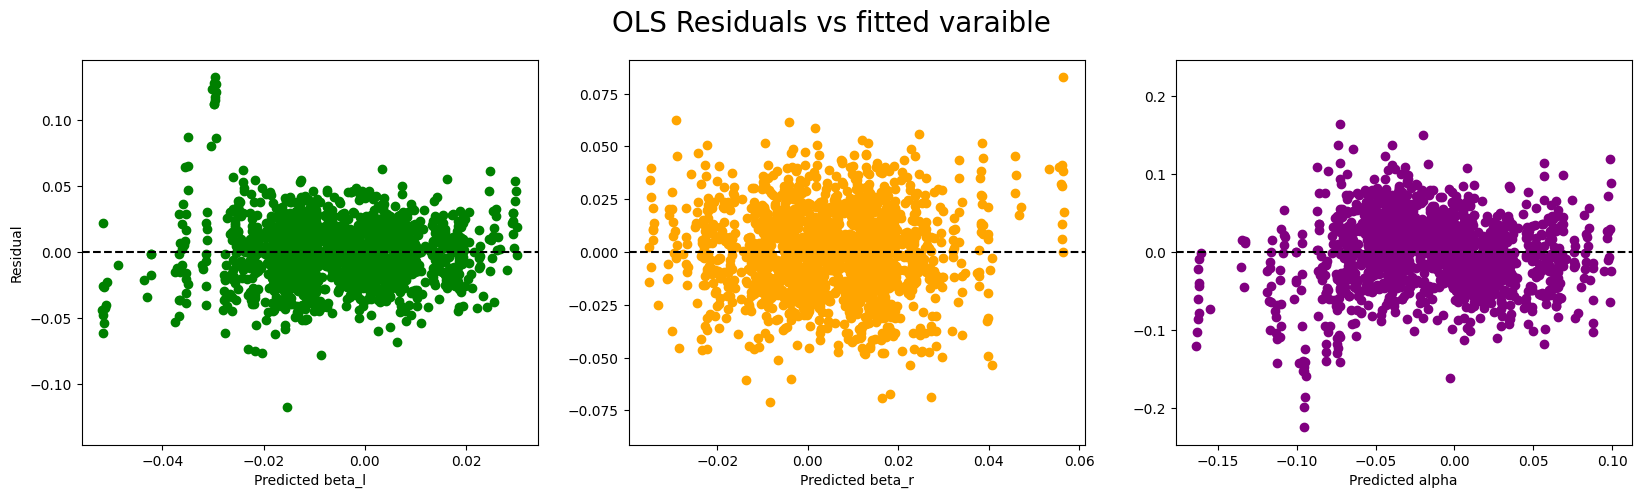

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
plt.suptitle("OLS Residuals vs fitted varaible", fontsize="20")

bound = max(abs(residuals_ols[...,0].min()),abs(residuals_ols[...,0].max()))
ax[0].set_ylim(-bound*1.1, bound*1.1)
ax[0].scatter(y_hat_ols[...,0], residuals_ols[...,0], color="green")
ax[0].axhline(0,linestyle='--', color='black')
ax[0].set_xlabel("Predicted beta_l")
ax[0].set_ylabel("Residual")

bound = max(abs(residuals_ols[...,1].min()),abs(residuals_ols[...,1].max()))
ax[1].set_ylim(-bound*1.1, bound*1.1)
ax[1].scatter(y_hat_ols[...,1], residuals_ols[...,1], color="orange")
ax[1].axhline(0,linestyle='--', color='black')
ax[1].set_xlabel("Predicted beta_r")

bound = max(abs(residuals_ols[...,2].min()),abs(residuals_ols[...,2].max()))
ax[2].set_ylim(-bound*1.1, bound*1.1)
ax[2].scatter(y_hat_ols[...,2], residuals_ols[...,2], color="purple")
ax[2].axhline(0,linestyle='--', color='black')
ax[2].set_xlabel("Predicted alpha")
plt.show()

In [32]:
# WLS regressor

# weights_l = 1 / (residuals_ols[:, 0] ** 2 + 1e-10)
# weights_r = 1 / (residuals_ols[:, 1] ** 2 + 1e-10)
# weights_alpha = 1 / (residuals_ols[:, 2] ** 2 + 1e-10)

weights_l = 1 / np.abs(residuals_ols[:, 0] + 1e-10)
weights_r = 1 / np.abs(residuals_ols[:, 1] + 1e-10)
weights_alpha = 1 / np.abs(residuals_ols[:, 2] + 1e-10)


# weights_l = 1 / (y_hat_ols[:, 0] ** 2 + 1e-10)
# weights_r = 1 / (y_hat_ols[:, 1] ** 2 + 1e-10)
# weights_alpha = 1 / (y_hat_ols[:, 2] ** 2 + 1e-10)


W_l = np.diag(weights_l)
W_r = np.diag(weights_r)
W_alpha = np.diag(weights_alpha)

W = block_diag(W_l, W_r, W_alpha)

X_expanded = np.kron(np.eye(3), X)

XTWX_inv = np.linalg.inv(X_expanded.T @ W @ X_expanded)
XTWy = X_expanded.T @ W @ Y.flatten(order='F')
theta_hat_wls_flat = XTWX_inv @ XTWy

theta_hat_wls = theta_hat_wls_flat.reshape(3, -1).T
y_hat_wls = X @ theta_hat_wls

In [33]:
residuals_wls = Y - y_hat_wls

In [34]:
np.linalg.norm(residuals_ols, axis=0), np.linalg.norm(residuals_wls, axis=0)

(array([0.95895543, 0.8204864 , 1.8036769 ]),
 array([0.95898351, 0.82049316, 1.80378163]))

In [35]:
std_residuals_beta_l = residuals_wls[:, 0] * np.sqrt(weights_l)
std_residuals_beta_r = residuals_wls[:, 1] * np.sqrt(weights_r)
std_residuals_alpha = residuals_wls[:, 2] * np.sqrt(weights_alpha)


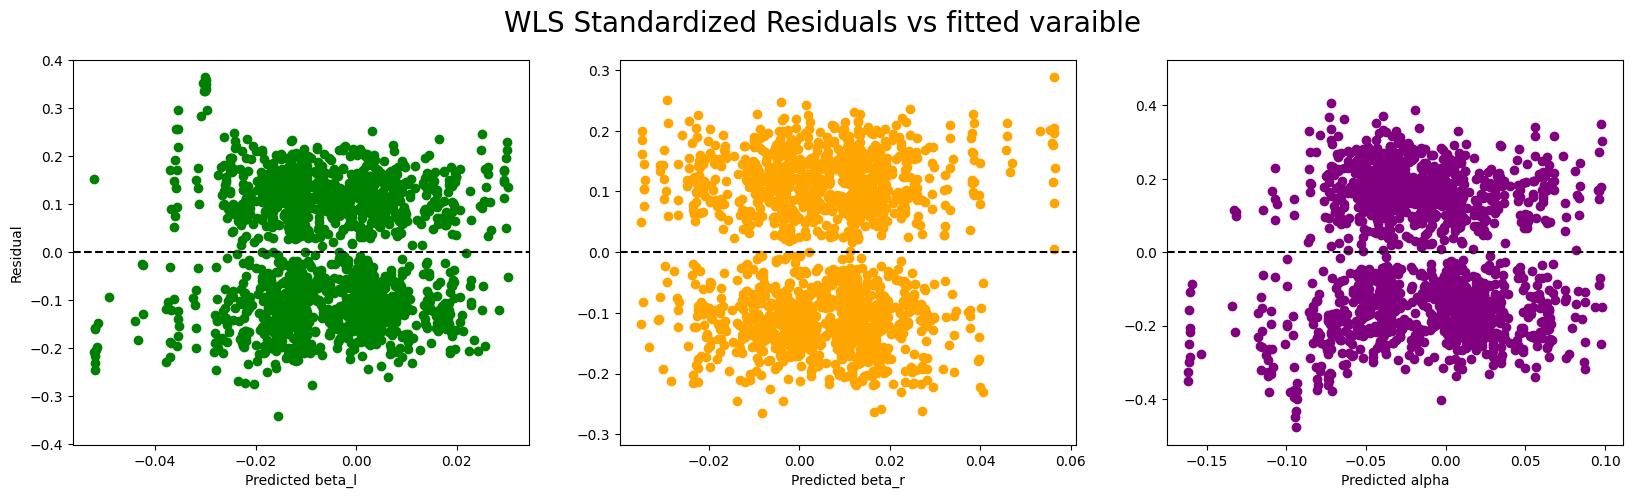

In [36]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
plt.suptitle("WLS Standardized Residuals vs fitted varaible", fontsize="20")

bound = max(abs(std_residuals_beta_l.min()),abs(std_residuals_beta_l.max()))
ax[0].set_ylim(-bound*1.1, bound*1.1)
ax[0].scatter(y_hat_wls[...,0], std_residuals_beta_l, color="green")
ax[0].axhline(0,linestyle='--', color='black')
ax[0].set_xlabel("Predicted beta_l")
ax[0].set_ylabel("Residual")

bound = max(abs(std_residuals_beta_r.min()),abs(std_residuals_beta_r.max()))
ax[1].set_ylim(-bound*1.1, bound*1.1)
ax[1].scatter(y_hat_wls[...,1], std_residuals_beta_r, color="orange")
ax[1].axhline(0,linestyle='--', color='black')
ax[1].set_xlabel("Predicted beta_r")

bound = max(abs(std_residuals_alpha.min()),abs(std_residuals_alpha.max()))
ax[2].set_ylim(-bound*1.1, bound*1.1)
ax[2].scatter(y_hat_wls[...,2], std_residuals_alpha, color="purple")
ax[2].axhline(0,linestyle='--', color='black')
ax[2].set_xlabel("Predicted alpha")
plt.show()

In [37]:
# %matplotlib tke

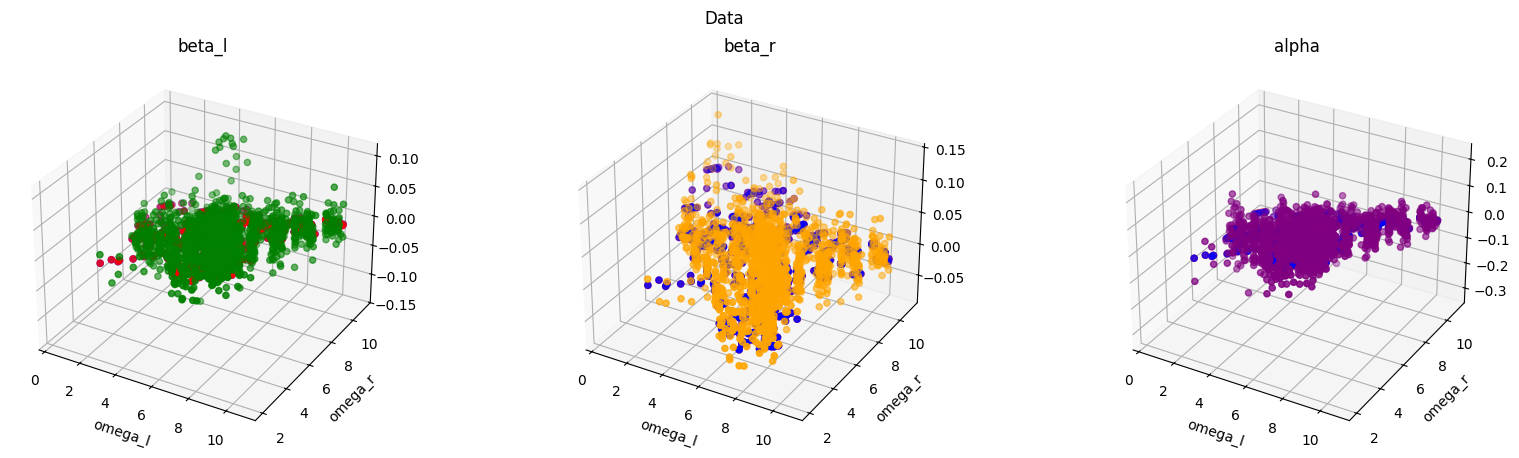

In [38]:
fig = plt.figure(figsize=(20, 5))
fig.suptitle("Data")

# Beta_l residuals
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(omega_l, omega_r, beta_l, color="green")
ax1.scatter(omega_l, omega_r, y_hat_ols[...,0], color="blue")
ax1.scatter(omega_l, omega_r, y_hat_wls[...,0], color="red")
ax1.set_xlabel("omega_l")
ax1.set_ylabel("omega_r")
ax1.set_title("beta_l")
# ax1.view_init(0, 0, 0)

# Beta_r residuals
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(omega_l, omega_r, beta_r, color="orange")
ax2.scatter(omega_l, omega_r, y_hat_ols[...,1], color="blue")
ax2.scatter(omega_l, omega_r, y_hat_wls[...,1], color="red")
ax2.set_xlabel("omega_l")
ax2.set_ylabel("omega_r")
ax2.set_title("beta_r")
# ax2.view_init(0, 0, 0)

# Alpha residuals
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(omega_l, omega_r, alpha, color="purple")
ax3.scatter(omega_l, omega_r, y_hat_ols[...,2], color="blue")
ax3.scatter(omega_l, omega_r, y_hat_wls[...,2], color="red")
ax3.set_xlabel("omega_l")
ax3.set_ylabel("omega_r")
ax3.set_title("alpha")
# ax3.view_init(0, 0, 0)

plt.show()

In [39]:
# Extract coefficients from WLS estimation
theta_0_l, theta_1_l, theta_2_l = theta_hat_wls[:, 0]  # Coefficients for beta_l
theta_0_r, theta_1_r, theta_2_r = theta_hat_wls[:, 1]  # Coefficients for beta_r
theta_0_alpha, theta_1_alpha, theta_2_alpha = theta_hat_wls[:, 2]  # Coefficients for alpha

# Create a grid of values for omega_l and omega_r
omega_l_grid, omega_r_grid = np.meshgrid(np.linspace(omega_l.min(), omega_l.max(), 100),
                                         np.linspace(omega_r.min(), omega_r.max(), 100))

# Calculate the corresponding beta_l, beta_r, and alpha values on the grid
beta_l_grid_wls = theta_0_l + theta_1_l * omega_l_grid + theta_2_l * omega_r_grid
beta_r_grid_wls = theta_0_r + theta_1_r * omega_l_grid + theta_2_r * omega_r_grid
alpha_grid_wls = theta_0_alpha + theta_1_alpha * omega_l_grid + theta_2_alpha * omega_r_grid

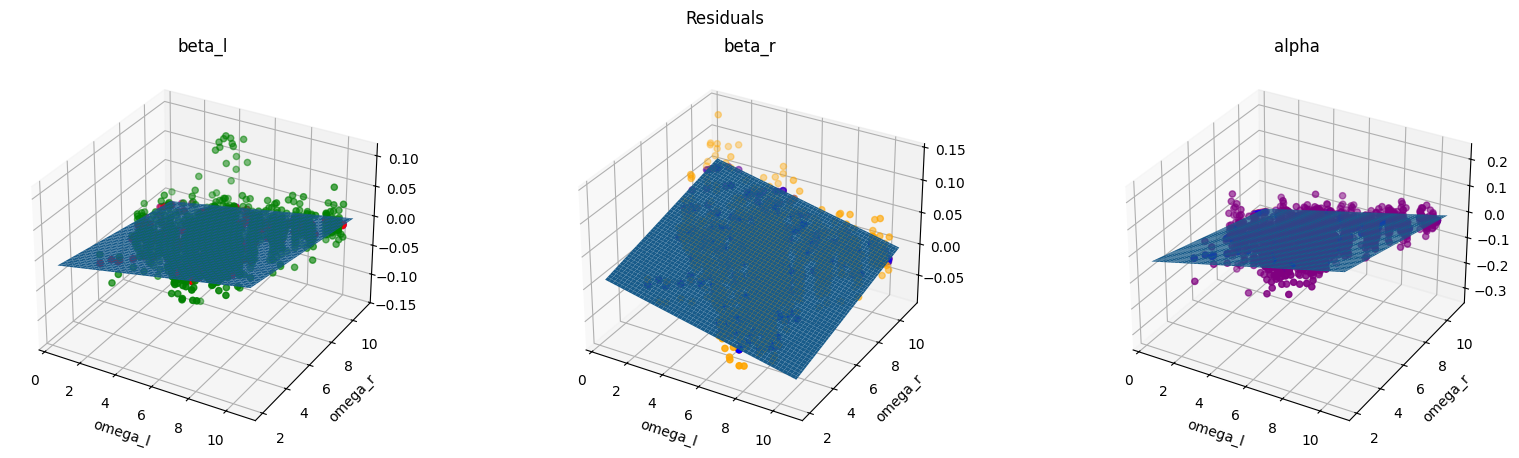

In [40]:
fig = plt.figure(figsize=(20, 5))
fig.suptitle("Residuals")



# Beta_l residuals
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(omega_l, omega_r, beta_l, color="green")
ax1.scatter(omega_l, omega_r, y_hat_ols[...,0], color="blue")
ax1.scatter(omega_l, omega_r, y_hat_wls[...,0], color="red")
ax1.plot_surface(omega_l_grid, omega_r_grid, beta_l_grid_wls, alpha=1)
ax1.set_xlabel("omega_l")
ax1.set_ylabel("omega_r")
ax1.set_title("beta_l")
# ax1.view_init(0, 0, 0)

# Beta_r residuals
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(omega_l, omega_r, beta_r, color="orange")
ax2.scatter(omega_l, omega_r, y_hat_ols[...,1], color="blue")
ax2.scatter(omega_l, omega_r, y_hat_wls[...,1], color="red")
ax2.plot_surface(omega_l_grid, omega_r_grid, beta_r_grid_wls, alpha=1)
ax2.set_xlabel("omega_l")
ax2.set_ylabel("omega_r")
ax2.set_title("beta_r")
# ax2.view_init(0, 0, 0)

# Alpha residuals
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(omega_l, omega_r, alpha, color="purple")
ax3.scatter(omega_l, omega_r, y_hat_ols[...,2], color="blue")
ax3.scatter(omega_l, omega_r, y_hat_wls[...,2], color="red")
ax3.plot_surface(omega_l_grid, omega_r_grid, alpha_grid_wls, alpha=1)
ax3.set_xlabel("omega_l")
ax3.set_ylabel("omega_r")
ax3.set_title("alpha")
# ax3.view_init(0, 0, 0)

plt.show()

In [41]:
print(f"beta_l r2: ols={r2_score(Y[...,0], y_hat_ols[...,0])}, wls={r2_score(Y[...,0], y_hat_wls[...,0])}")
print(f"beta_r r2: ols={r2_score(Y[...,1], y_hat_ols[...,1])}, wls={r2_score(Y[...,1], y_hat_wls[...,1])}")
print(f"alpha r2: ols={r2_score(Y[...,2], y_hat_ols[...,2])}, wls={r2_score(Y[...,2], y_hat_wls[...,2])}")

beta_l r2: ols=0.24934621247680377, wls=0.24930225098925063
beta_r r2: ols=0.36154393893429426, wls=0.36153341921867344
alpha r2: ols=0.49030039050303986, wls=0.4902411989430383


In [42]:
df_1 = pd.read_csv("data/1.csv", index_col=0) 

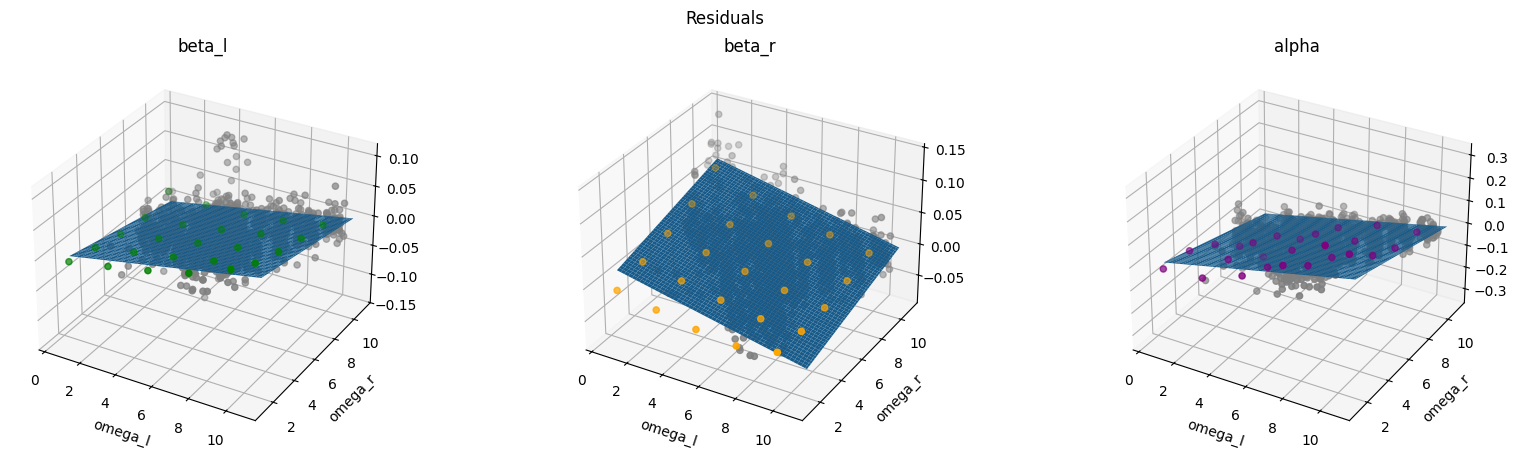

In [43]:
fig = plt.figure(figsize=(20, 5))
fig.suptitle("Residuals")

omega_l_gt = df_1.wheel_l.values
omega_r_gt = df_1.wheel_r.values
beta_l_gt = df_1.beta_l.values
beta_r_gt = df_1.beta_r.values
alpha_gt = df_1.alpha.values

# Beta_l residuals
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(omega_l_gt, omega_r_gt, beta_l_gt, color="green")
ax1.scatter(omega_l, omega_r, beta_l, color="gray")
ax1.plot_surface(omega_l_grid, omega_r_grid, beta_l_grid_wls, alpha=1)
ax1.set_xlabel("omega_l")
ax1.set_ylabel("omega_r")
ax1.set_title("beta_l")
# ax1.view_init(0, 0, 0)

# Beta_r residuals
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(omega_l_gt, omega_r_gt, beta_r_gt, color="orange")
ax2.scatter(omega_l, omega_r, beta_r, color="gray")
ax2.plot_surface(omega_l_grid, omega_r_grid, beta_r_grid_wls, alpha=1)
ax2.set_xlabel("omega_l")
ax2.set_ylabel("omega_r")
ax2.set_title("beta_r")
# ax2.view_init(0, 0, 0)

# Alpha residuals
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(omega_l_gt, omega_r_gt, alpha_gt, color="purple")
ax3.scatter(omega_l, omega_r, alpha, color="gray")
ax3.plot_surface(omega_l_grid, omega_r_grid, alpha_grid_wls, alpha=1)
ax3.set_xlabel("omega_l")
ax3.set_ylabel("omega_r")
ax3.set_title("alpha")
# ax3.view_init(0, 0, 0)

plt.show()

In [44]:
X = np.column_stack((np.ones(len(omega_l_gt)), omega_l_gt, omega_r_gt))
Y = np.column_stack((beta_l_gt, beta_r_gt, alpha_gt))

In [45]:
y_hat_wls_gt = X @ theta_hat_wls

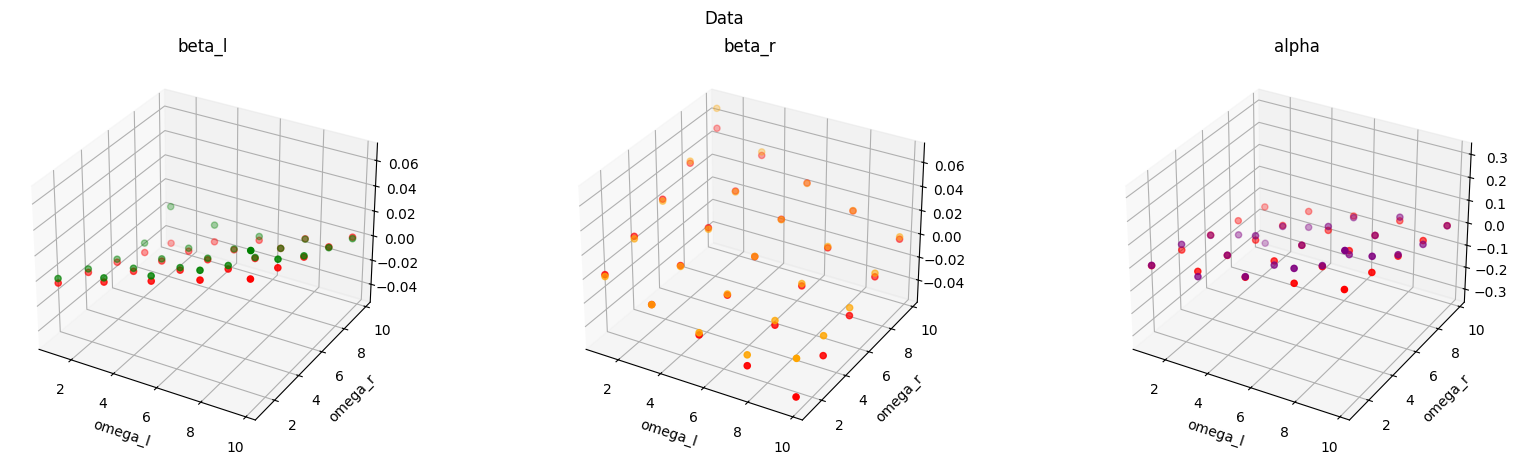

In [46]:
fig = plt.figure(figsize=(20, 5))
fig.suptitle("Data")

# Beta_l residuals
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(omega_l_gt, omega_r_gt, beta_l_gt, color="green")
ax1.scatter(omega_l_gt, omega_r_gt, y_hat_wls_gt[...,0], color="red")
ax1.set_xlabel("omega_l")
ax1.set_ylabel("omega_r")
ax1.set_title("beta_l")
# ax1.view_init(0, 0, 0)

# Beta_r residuals
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(omega_l_gt, omega_r_gt, beta_r_gt, color="orange")
ax2.scatter(omega_l_gt, omega_r_gt, y_hat_wls_gt[...,1], color="red")
ax2.set_xlabel("omega_l")
ax2.set_ylabel("omega_r")
ax2.set_title("beta_r")
# ax2.view_init(0, 0, 0)

# Alpha residuals
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(omega_l_gt, omega_r_gt, alpha_gt, color="purple")
ax3.scatter(omega_l_gt, omega_r_gt, y_hat_wls_gt[...,2], color="red")
ax3.set_xlabel("omega_l")
ax3.set_ylabel("omega_r")
ax3.set_title("alpha")
# ax3.view_init(0, 0, 0)

plt.show()

In [47]:
print(f"beta_l_gt r2: wls={r2_score(Y[...,0], y_hat_wls_gt[...,0])}")
print(f"beta_r_gt r2: wls={r2_score(Y[...,1], y_hat_wls_gt[...,1])}")
print(f"alpha_gt r2: wls={r2_score(Y[...,2], y_hat_wls_gt[...,2])}")

beta_l_gt r2: wls=0.8524885605724235
beta_r_gt r2: wls=0.8649902876917238
alpha_gt r2: wls=0.78389006684018


In [48]:
theta_hat_ols, theta_hat_wls

(array([[-0.00466157,  0.00234246, -0.00133328],
        [ 0.00551189, -0.00604546,  0.01681407],
        [-0.00488107,  0.00559457, -0.01663347]]),
 array([[-0.00423618,  0.0020845 , -0.00167233],
        [ 0.00551663, -0.00603065,  0.01666905],
        [-0.00496088,  0.00560791, -0.01643605]]))